In [16]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import joblib
import glob
import os
from IPython.display import display, Markdown

ref_order = ["hg19", "grch38", "chm13"]
sb.set()

In [2]:
metadata = pd.read_csv("../lra_sr_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [24]:
data = joblib.load("../stats/single_sample_stats.jl")
#weird_sample = data["sample"] == "NA18939"
data = data[~weird_sample & ~(data["merge"].str.startswith("removed"))]

In [25]:
def plot_sv_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by svtype with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], len(subdat)])
        subdat["count"] = 1
        tygrp = subdat.groupby(["svtype"]).sum()["count"]
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "DEL", tygrp.loc["DEL"]])
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "INS", tygrp.loc["INS"]])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "svcount"])
    p = sb.catplot(data=view, x="reference", y="svcount", hue="Superpopulation", order=ref_order)
    p.set(title="SV Counts per-sample by reference", xlabel="Reference", ylabel="Count")
    plt.show()
    p = sb.catplot(data=view_bytype, x="svtype", y="svcount", hue="Superpopulation", col="reference", col_order=ref_order)
    p.set(title="SV Counts per-sample by reference/SVTYPE", xlabel="Reference", ylabel="Count")
    plt.show()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference"]).describe())
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype"]).describe())

    return view, view_bytype
    
def plot_svsize_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by sizebin with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        for size, subdat2 in subdat.groupby("szbin"):
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], size, len(subdat2)])
        for idx2, subdat2 in subdat.groupby(["svtype", "szbin"]):
            svtype, szbin = idx2        
            view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], svtype, szbin, len(subdat2)])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "szbin", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "szbin", "svcount"])
    p = sb.barplot(data=view, x="szbin", y="svcount", order=truvari.SZBINS[1:], hue="reference", hue_order=ref_order)
    p.set(title=f"SV count by SV size")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    p = sb.catplot(data=view_bytype, kind="bar", x="szbin", y="svcount", col="reference", hue="svtype", col_order=ref_order)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha="right") for ax in p.axes.flat]
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV count by SV size/type per-reference')
    plt.show()
    view["szbin"] = view["szbin"].astype(SZBINTY)
    view_bytype["szbin"] = view_bytype["szbin"].astype(SZBINTY)
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference", "szbin"]).describe())

    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype", "szbin"]).describe())
    return view, view_bytype

def plot_hethom_stats(m_data):
    """
    Creates a view of the data by reference/sample/project and summarizes the GT counts and ratios
    Creates a plot, also
    Return the data view
    """
    view = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        subdat["count"] = 1
        gtgrp = subdat.groupby(["GT"]).sum()["count"]    
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "TOT", gtgrp.loc["HET"], gtgrp.loc["HOM"]])
        for idx2, subdat2 in subdat.groupby(["svtype"]):
            if idx2 not in ["DEL", "INS"]: continue
            gtgrp = subdat2.groupby(["GT"]).sum()["count"]   
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], idx2, gtgrp.loc["HET"], gtgrp.loc["HOM"]])
    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svtype", "HET", "HOM"])
    view["Ratio"] = view["HET"] / view["HOM"]

    p = sb.catplot(data=view[view["svtype"] == "TOT"], x="reference", y="Ratio", hue="Superpopulation", order=ref_order)
    p.set(title="Het/Hom ratio per-sample by reference", xlabel="Reference", ylabel="Het/Hom Ratio")
    plt.show()
    
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(view.groupby(["reference", "svtype"])["Ratio"].describe())
    return view


First, let's look at just the generic "strict" strategy's numbers

# Strict Merging - Per-Sample Stats

## SVCounts per-sample

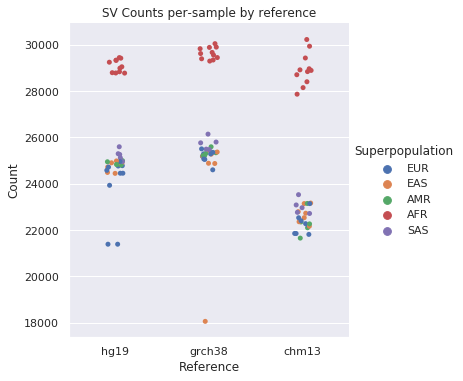

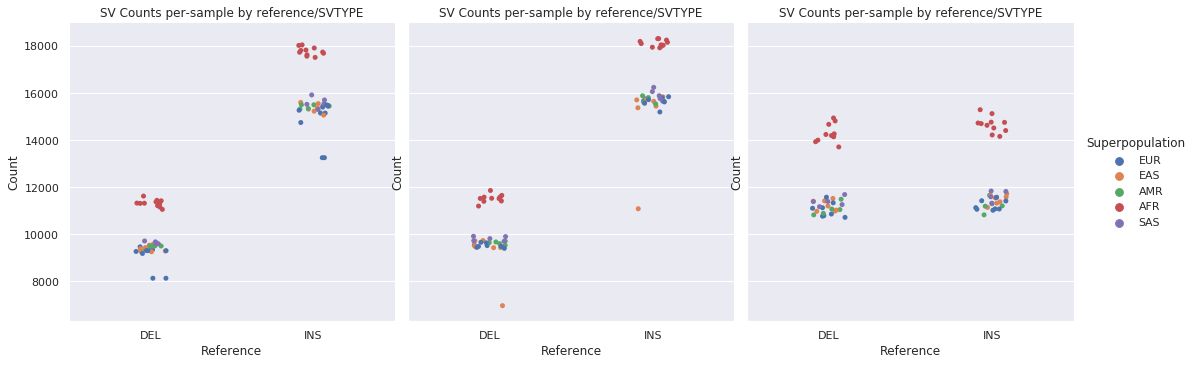

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 24,499 3,045 21,652 22,332 22,880 28,218 30,235
grch38         36 26,442 2,485 18,054 25,216 25,461 29,362 30,056
hg19           39 25,860 2,213 21,388 24,744 24,961 28,786 29,453

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,116 1,489 10,719 11,044 11,393 13,951 14,942
          INS         36 12,383 1,562 10,827 11,276 11,582 14,268 15,293
grch38    DEL         36 10,124 1,051  6,968  9,518  9,708 11,405 11,862
          INS         36 16,317 1,444 11,086 15,659 15,803 17,958 18,314
hg19      DEL         39  9,903   958  8,133  9,323  9,502 11,110 11,624
          INS         39 15,957 1,263 13,255 15,320 15,495 17,542 18,048

## SVCounts by SZBIN per-sample

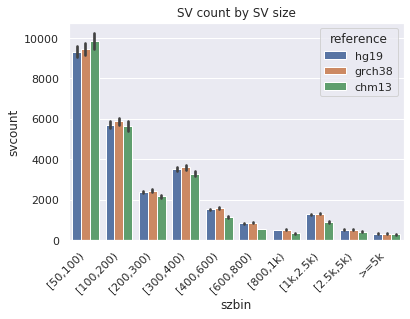

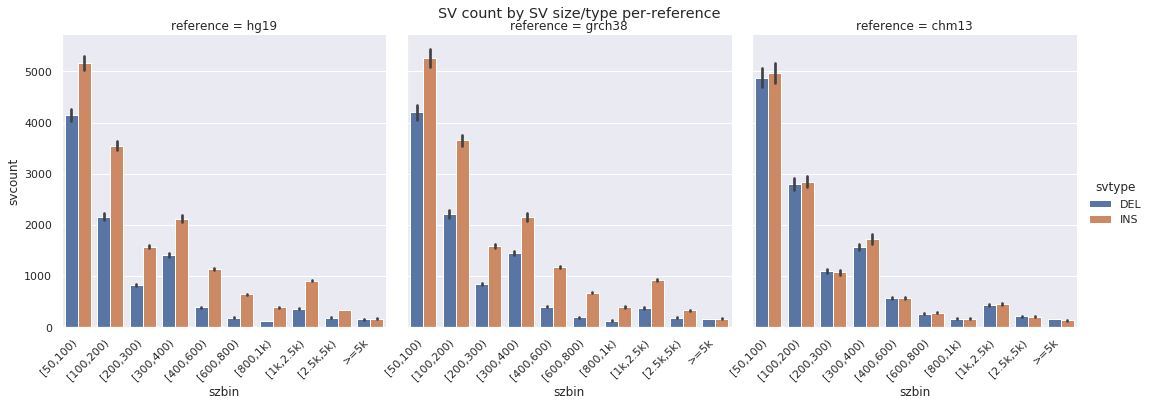

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       36 9,837 1,201 8,672 9,003 9,196 11,344 12,041
          [100,200)      36 5,641   716 4,980 5,104 5,282  6,500  6,913
          [200,300)      36 2,164   256 1,908 1,976 2,036  2,434  2,736
          [300,400)      36 3,285   462 2,855 2,942 3,040  3,826  4,293
          [400,600)      36 1,138   130   969 1,043 1,093  1,267  1,398
          [600,800)      36   542    73   448   491   516    595    723
          [800,1k)       36   325    42   263   295   312    359    431
          [1k,2.5k)      36   881   112   740   799   828  1,014  1,088
          [2.5k,5k)      36   407    51   336   370   390    458    500
          >=5k           36   279    37   230   254   267    315    343
grch38    [50,100)       36 9,460   980 6,282 8,942 9,081 10,640 10,941
          [100,200)      36 5,879   561 3,955 5,590 5,682  6,544  6,699
          [200,300)      36 2,430   217 1,647 2,334 2,366  2,637  2,760
          [300,400)      36 3,598   361 2,535 3,392 3,446  4,019  4,194
          [400,600)      36 1,572   115 1,142 1,520 1,556  1,682  1,761
          [600,800)      36   862    69   607   830   854    912    965
          [800,1k)       36   517    42   358   493   521    542    588
          [1k,2.5k)      36 1,301   100   942 1,247 1,289  1,390  1,476
          [2.5k,5k)      36   509    48   368   482   502    536    606
          >=5k           36   315    30   218   300   314    336    362
hg19      [50,100)       39 9,310   879 7,587 8,837 8,976 10,423 10,794
          [100,200)      39 5,709   485 4,743 5,450 5,520  6,330  6,523
          [200,300)      39 2,388   190 2,007 2,284 2,334  2,595  2,716
          [300,400)      39 3,523   330 2,917 3,320 3,385  3,946  4,136
          [400,600)      39 1,511   104 1,264 1,459 1,488  1,582  1,715
          [600,800)      39   821    56   720   785   804    872    929
          [800,1k)       39   502    35   429   480   502    522    568
          [1k,2.5k)      39 1,269    96 1,063 1,202 1,248  1,356  1,450
          [2.5k,5k)      39   512    46   421   483   506    537    609
          >=5k           39   314    31   237   298   312    334    361

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,869 593 4,295 4,460 4,584 5,583 5,955
                 [100,200)      36 2,800 363 2,396 2,538 2,632 3,261 3,451
                 [200,300)      36 1,095 126   957 1,004 1,040 1,224 1,356
                 [300,400)      36 1,563 185 1,374 1,426 1,477 1,751 1,972
                 [400,600)      36   566  72   486   515   538   624   725
                 [600,800)      36   263  37   200   240   258   286   351
                 [800,1k)       36   164  21   131   150   158   178   216
                 [1k,2.5k)      36   435  66   355   385   406   506   573
                 [2.5k,5k)      36   209  28   180   187   195   236   268
                 >=5k           36   153  21   118   140   146   175   193
          INS    [50,100)       36 4,968 612 4,377 4,521 4,670 5,729 6,096
                 [100,200)      36 2,841 356 2,486 2,588 2,668 3,264 3,462
                 [200,300)      36 1,069 135   915   965 1,020 1,216 1,380
                 [300,400)      36 1,722 279 1,481 1,517 1,568 2,050 2,321
                 [400,600)      36   571  65   460   528   560   622   699
                 [600,800)      36   279  40   215   252   267   306   372
                 [800,1k)       36   161  24   126   142   158   182   215
                 [1k,2.5k)      36   446  49   372   412   428   495   542
                 [2.5k,5k)      36   199  25   153   176   196   217   253
                 >=5k           36   127  18    99   113   122   143   159
grch38    DEL    [50,100)       36 4,203 450 2,800 3,958 4,051 4,707 4,918
                 [100,200)      36 2,217 243 1,491 2,082 2,126 2,503 2,621
                 [200,300)      36   841  86   588   790   812   908 1,002
                 [300,400)      36 1,446 126 1,105 1,364 1,403 1,590 1,651
                 [400,600)      36   397  44   281   368   385   436   488
                 [600,800)      36   188  25   129   172   184   209   232
                 [800,1k)       36   126  13    84   120   124   133   149
                 [1k,2.5k)      36   373  47   260   338   362   418   467
                 [2.5k,5k)      36   180  26   125   163   170   197   237
                 >=5k           36   154  16   105   144   153   161   187
          INS    [50,100)       36 5,257 534 3,482 4,982 5,040 5,878 6,100
                 [100,200)      36 3,662 323 2,464 3,510 3,566 4,012 4,131
                 [200,300)      36 1,589 135 1,059 1,532 1,558 1,711 1,782
                 [300,400)      36 2,152 238 1,430 2,022 2,068 2,424 2,556
                 [400,600)      36 1,175  77   861 1,142 1,170 1,214 1,301
                 [600,800)      36   674  49   478   657   678   701   756
                 [800,1k)       36   391  31   274   376   396   407   439
                 [1k,2.5k)      36   928  59   682   903   928   954 1,040
                 [2.5k,5k)      36   329  26   243   314   330   346   386
                 >=5k           36   161  16   113   151   162   169   188
hg19      DEL    [50,100)       39 4,141 404 3,409 3,908 3,972 4,638 4,864
                 [100,200)      39 2,161 217 1,750 2,041 2,076 2,428 2,566
                 [200,300)      39   820  79   692   762   793   880   970
                 [300,400)      39 1,408 117 1,191 1,326 1,368 1,556 1,607
                 [400,600)      39   383  40   319   354   371   414   481
                 [600,800)      39   178  24   146   160   172   196   231
                 [800,1k)       39   120  11   100   112   121   128   145
                 [1k,2.5k)      39   360  49   276   328   349   397   455
                 [2.5k,5k)      39   181  25   138   165   173   200   235
                 >=5k           39   151  17   112   140   151   162   186
          INS    [50,100)       39 5,169 480 4,178 4

## SV HET/HOM Ratios

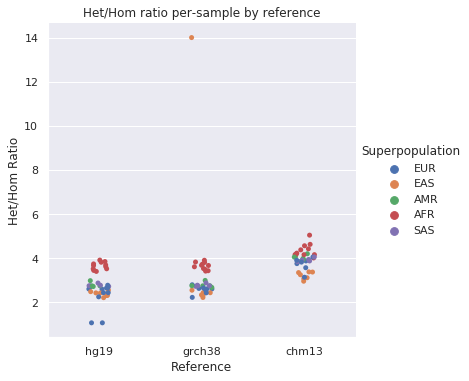

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     36.00  3.55 0.42 2.64 3.37 3.60 3.80  4.57
          INS     36.00  4.28 0.53 3.28 4.10 4.30 4.58  5.58
          TOT     36.00  3.89 0.47 2.95 3.70 3.94 4.16  5.04
grch38    DEL     36.00  3.10 1.86 2.03 2.54 2.66 3.34 13.58
          INS     36.00  3.33 1.96 2.23 2.64 2.80 3.61 14.29
          TOT     36.00  3.24 1.92 2.21 2.59 2.74 3.50 14.01
hg19      DEL     39.00  2.70 0.61 1.08 2.36 2.65 3.24  3.65
          INS     39.00  2.88 0.69 1.05 2.56 2.75 3.54  4.09
          TOT     39.00  2.81 0.66 1.06 2.46 2.72 3.42  3.91

In [26]:
ch1_data = data[(data["merge"] == "strict")]
display(Markdown("# Strict Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
hide1 = plot_sv_counts(ch1_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
hide2 = plot_svsize_counts(ch1_data)
display(Markdown("## SV HET/HOM Ratios"))
hide3 = plot_hethom_stats(ch1_data)

Then, we'll look at a comparison of the strategies and what it means for the truth set SV counts by comparing with 'exact' and 'loose' merges

# Exact Merging - Per-Sample Stats

## SVCounts per-sample

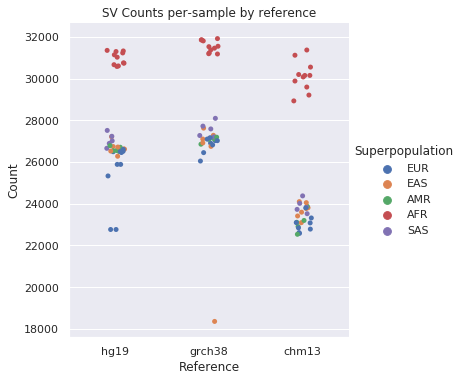

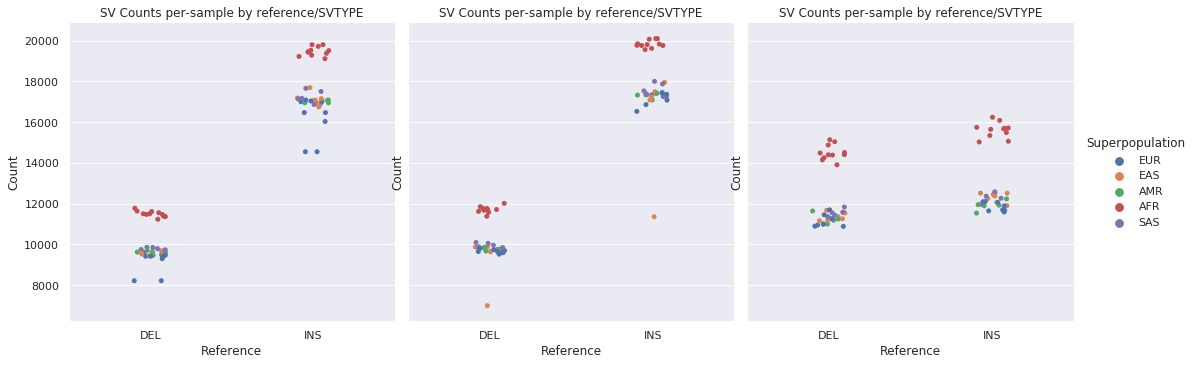

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 25,451 3,190 22,533 23,106 23,802 29,305 31,370
grch38         36 28,220 2,688 18,355 27,025 27,198 31,202 31,917
hg19           39 27,630 2,319 22,763 26,509 26,707 30,594 31,352

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,291 1,518 10,885 11,232 11,546 14,174 15,133
          INS         36 13,160 1,681 11,536 11,944 12,316 15,131 16,237
grch38    DEL         36 10,281 1,073  6,996  9,670  9,856 11,588 12,014
          INS         36 17,939 1,638 11,359 17,286 17,414 19,652 20,095
hg19      DEL         39 10,054   976  8,218  9,482  9,645 11,300 11,773
          INS         39 17,576 1,356 14,545 16,945 17,082 19,167 19,800

## SVCounts by SZBIN per-sample

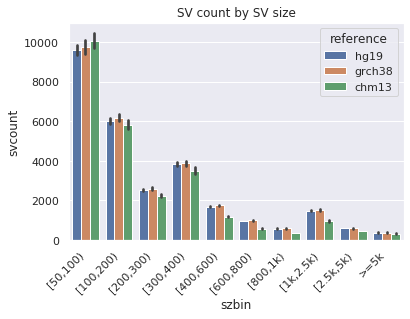

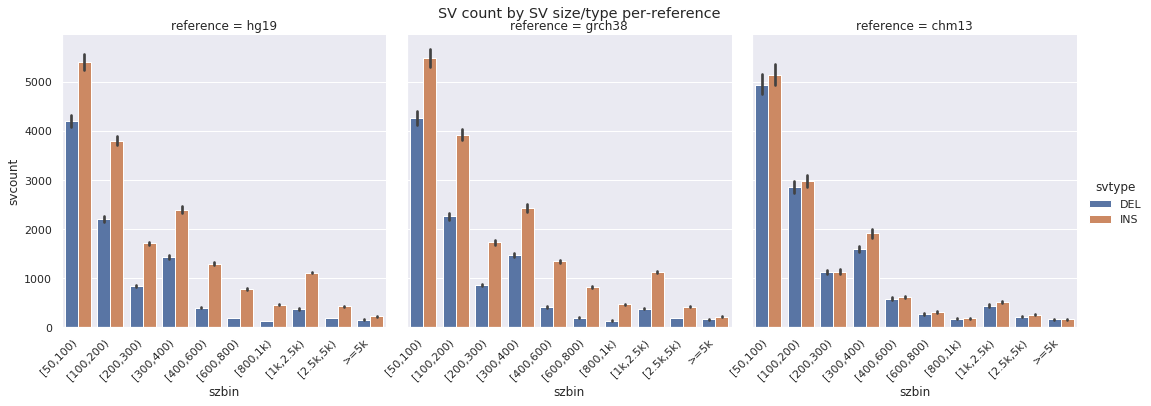

svcount                                             
                      count   mean   std   min   25%   50%    75%    max
reference szbin                                                         
chm13     [50,100)       36 10,072 1,237 8,908 9,204 9,410 11,620 12,323
          [100,200)      36  5,822   746 5,126 5,301 5,462  6,708  7,147
          [200,300)      36  2,243   267 1,962 2,064 2,112  2,526  2,820
          [300,400)      36  3,494   485 3,064 3,154 3,230  4,042  4,532
          [400,600)      36  1,184   135 1,008 1,090 1,138  1,308  1,461
          [600,800)      36    567    76   479   511   539    626    748
          [800,1k)       36    343    46   276   311   330    382    461
          [1k,2.5k)      36    955   129   799   861   895  1,104  1,195
          [2.5k,5k)      36    456    59   369   417   434    518    558
          >=5k           36    314    45   250   281   298    356    395
grch38    [50,100)       36  9,757 1,020 6,327 9,224 9,364 10,985 11,243
          [100,200)      36  6,182   596 4,010 5,912 5,986  6,852  7,019
          [200,300)      36  2,583   233 1,677 2,484 2,524  2,796  2,907
          [300,400)      36  3,890   387 2,592 3,684 3,734  4,328  4,489
          [400,600)      36  1,749   137 1,168 1,704 1,738  1,858  1,963
          [600,800)      36  1,003    87   629   973   999  1,056  1,134
          [800,1k)       36    589    53   374   562   592    619    674
          [1k,2.5k)      36  1,504   126   972 1,454 1,487  1,583  1,698
          [2.5k,5k)      36    597    58   380   570   588    630    699
          >=5k           36    367    38   226   355   364    387    427
hg19      [50,100)       39  9,604   906 7,790 9,115 9,252 10,740 11,092
          [100,200)      39  6,003   507 4,931 5,760 5,809  6,627  6,831
          [200,300)      39  2,539   201 2,103 2,426 2,482  2,756  2,871
          [300,400)      39  3,819   332 3,253 3,612 3,694  4,238  4,425
          [400,600)      39  1,683   116 1,380 1,636 1,672  1,756  1,906
          [600,800)      39    957    65   814   917   951  1,009  1,078
          [800,1k)       39    575    44   481   549   575    600    651
          [1k,2.5k)      39  1,474   109 1,225 1,407 1,451  1,556  1,675
          [2.5k,5k)      39    607    51   503   579   599    635    705
          >=5k           39    369    36   283   356   368    389    427

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,936 604 4,362 4,512 4,644 5,664 6,035
                 [100,200)      36 2,849 372 2,436 2,574 2,672 3,331 3,519
                 [200,300)      36 1,113 129   966 1,020 1,057 1,246 1,376
                 [300,400)      36 1,584 189 1,396 1,444 1,499 1,778 1,991
                 [400,600)      36   576  73   490   524   546   636   730
                 [600,800)      36   266  37   203   242   259   289   355
                 [800,1k)       36   165  21   134   151   160   181   219
                 [1k,2.5k)      36   437  67   356   387   408   510   580
                 [2.5k,5k)      36   210  29   180   188   196   239   269
                 >=5k           36   154  21   119   142   146   177   195
          INS    [50,100)       36 5,136 637 4,516 4,670 4,818 5,911 6,294
                 [100,200)      36 2,973 377 2,581 2,701 2,792 3,413 3,628
                 [200,300)      36 1,130 144   964 1,024 1,074 1,285 1,444
                 [300,400)      36 1,910 299 1,649 1,697 1,745 2,254 2,541
                 [400,600)      36   608  69   487   562   592   659   737
                 [600,800)      36   302  43   241   271   288   335   398
                 [800,1k)       36   178  27   136   156   172   201   242
                 [1k,2.5k)      36   518  65   428   470   493   588   648
                 [2.5k,5k)      36   246  33   185   220   242   275   307
                 >=5k           36   160  26   124   139   151   181   205
grch38    DEL    [50,100)       36 4,267 460 2,808 4,016 4,107 4,786 4,980
                 [100,200)      36 2,259 248 1,500 2,116 2,163 2,549 2,663
                 [200,300)      36   856  88   591   804   831   922 1,024
                 [300,400)      36 1,464 129 1,108 1,383 1,420 1,616 1,669
                 [400,600)      36   404  46   283   377   390   446   492
                 [600,800)      36   190  25   129   174   184   210   235
                 [800,1k)       36   128  13    85   122   127   136   149
                 [1k,2.5k)      36   376  48   261   341   365   419   475
                 [2.5k,5k)      36   181  26   126   164   173   199   239
                 >=5k           36   154  17   105   145   154   163   187
          INS    [50,100)       36 5,490 565 3,519 5,204 5,253 6,144 6,328
                 [100,200)      36 3,924 355 2,510 3,767 3,820 4,291 4,400
                 [200,300)      36 1,726 151 1,086 1,671 1,702 1,854 1,938
                 [300,400)      36 2,426 262 1,484 2,294 2,338 2,704 2,840
                 [400,600)      36 1,344 100   885 1,319 1,344 1,404 1,491
                 [600,800)      36   812  68   500   788   814   844   907
                 [800,1k)       36   461  43   289   441   464   488   525
                 [1k,2.5k)      36 1,127  87   711 1,098 1,130 1,171 1,259
                 [2.5k,5k)      36   416  38   254   401   420   438   478
                 >=5k           36   213  24   121   203   215   224   250
hg19      DEL    [50,100)       39 4,203 411 3,449 3,967 4,026 4,709 4,925
                 [100,200)      39 2,202 221 1,772 2,076 2,111 2,468 2,609
                 [200,300)      39   835  81   697   776   806   892   989
                 [300,400)      39 1,425 120 1,200 1,348 1,387 1,579 1,623
                 [400,600)      39   390  42   323   357   380   425   485
                 [600,800)      39   180  24   147   162   172   198   234
                 [800,1k)       39   122  11   101   112   121   128   147
                 [1k,2.5k)      39   363  50   278   330   353   400   462
                 [2.5k,5k)      39   183  25   139   166   175   201   237
                 >=5k           39   152  17   112   142   153   162   186
          INS    [50,100)       39 5,400 501 4,341 5

## SV HET/HOM Ratios

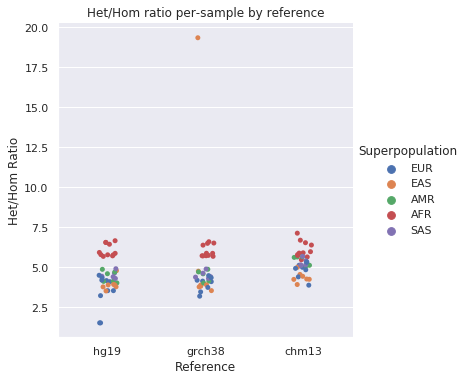

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     36.00  3.94 0.50 2.91 3.65 3.96 4.21  5.13
          INS     36.00  7.48 1.38 4.81 6.60 7.32 8.19 10.67
          TOT     36.00  5.29 0.76 3.89 4.92 5.24 5.70  7.14
grch38    DEL     36.00  3.43 1.98 2.24 2.76 2.95 3.75 14.55
          INS     36.00  7.03 3.33 3.90 5.33 6.22 7.95 24.13
          TOT     36.00  5.17 2.61 3.20 4.09 4.54 5.73 19.35
hg19      DEL     39.00  2.99 0.70 1.15 2.61 2.92 3.65  4.10
          INS     39.00  6.25 1.91 1.81 5.29 5.93 7.83  9.87
          TOT     39.00  4.57 1.19 1.53 3.92 4.41 5.70  6.67

In [27]:
exact_data = data[(data["merge"] == "exact")]

display(Markdown("# Exact Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
plot_sv_counts(exact_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
plot_svsize_counts(exact_data)
display(Markdown("## SV HET/HOM Ratios"))
hide = plot_hethom_stats(exact_data)

# Loose Merging - Per-Sample Stats

## SVCounts per-sample

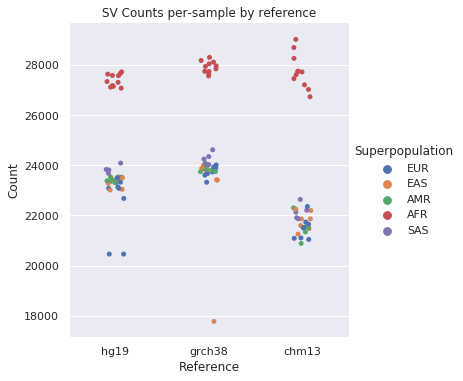

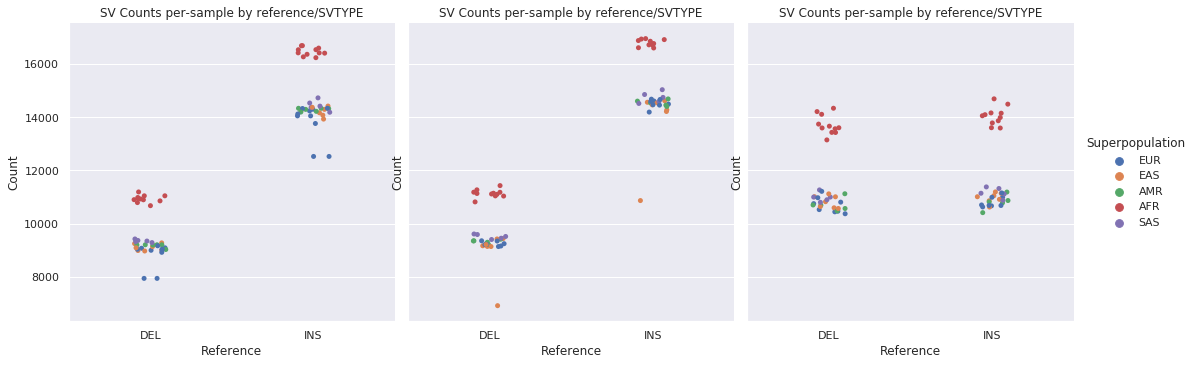

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 23,555 2,867 20,882 21,512 22,018 27,065 29,015
grch38         36 24,930 2,261 17,775 23,748 24,001 27,658 28,298
hg19           39 24,369 2,043 20,458 23,315 23,500 27,092 27,718

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 11,680 1,393 10,366 10,673 10,994 13,421 14,331
          INS         36 11,875 1,480 10,408 10,844 11,122 13,644 14,684
grch38    DEL         36  9,802   986  6,913  9,213  9,404 11,033 11,424
          INS         36 15,128 1,281 10,862 14,480 14,608 16,630 16,947
hg19      DEL         39  9,585   903  7,938  9,033  9,201 10,728 11,186
          INS         39 14,784 1,146 12,520 14,184 14,329 16,247 16,683

## SVCounts by SZBIN per-sample

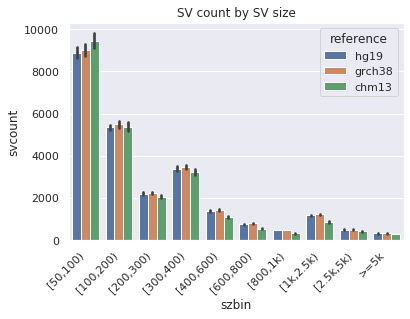

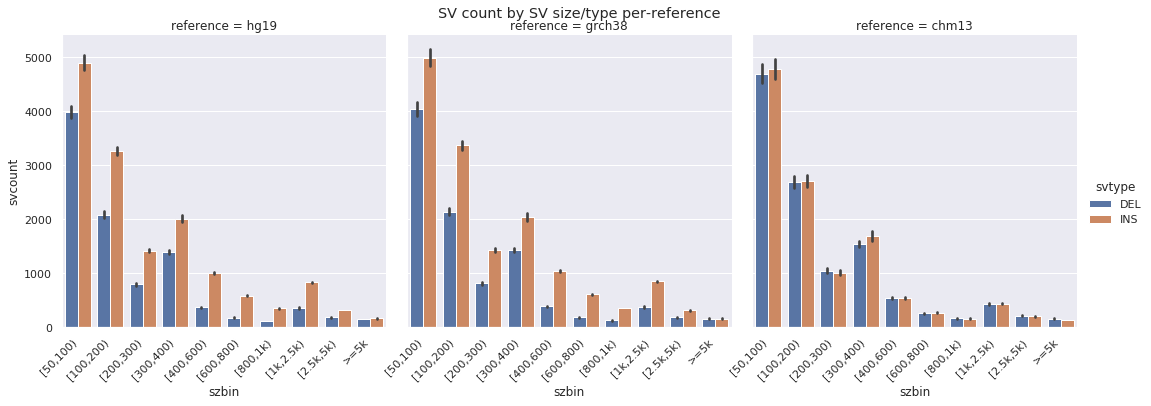

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       36 9,457 1,125 8,344 8,678 8,846 10,879 11,509
          [100,200)      36 5,381   665 4,775 4,905 5,037  6,172  6,580
          [200,300)      36 2,053   236 1,816 1,889 1,936  2,298  2,591
          [300,400)      36 3,215   450 2,794 2,882 2,978  3,744  4,208
          [400,600)      36 1,080   121   926   989 1,034  1,201  1,323
          [600,800)      36   519    70   428   472   497    570    699
          [800,1k)       36   313    39   253   284   300    344    411
          [1k,2.5k)      36   858   109   723   779   805    984  1,060
          [2.5k,5k)      36   402    50   334   366   385    452    493
          >=5k           36   278    37   230   253   266    314    343
grch38    [50,100)       36 9,030   908 6,205 8,564 8,663 10,148 10,414
          [100,200)      36 5,506   503 3,878 5,238 5,328  6,115  6,246
          [200,300)      36 2,242   191 1,619 2,148 2,184  2,430  2,551
          [300,400)      36 3,463   343 2,506 3,263 3,314  3,872  4,021
          [400,600)      36 1,423    92 1,109 1,380 1,406  1,508  1,578
          [600,800)      36   784    60   594   755   772    821    888
          [800,1k)       36   473    37   352   454   474    494    546
          [1k,2.5k)      36 1,208    90   931 1,156 1,188  1,292  1,373
          [2.5k,5k)      36   490    46   364   463   482    521    584
          >=5k           36   310    29   217   294   308    328    358
hg19      [50,100)       39 8,882   821 7,319 8,438 8,547  9,938 10,267
          [100,200)      39 5,342   441 4,507 5,102 5,166  5,914  6,090
          [200,300)      39 2,200   173 1,882 2,101 2,139  2,392  2,497
          [300,400)      39 3,391   314 2,842 3,193 3,244  3,798  3,957
          [400,600)      39 1,369    87 1,177 1,310 1,348  1,420  1,553
          [600,800)      39   746    49   671   712   730    786    849
          [800,1k)       39   459    31   404   436   457    478    521
          [1k,2.5k)      39 1,179    89 1,013 1,118 1,153  1,265  1,353
          [2.5k,5k)      39   493    44   407   462   483    518    585
          >=5k           39   309    30   235   294   307    328    356

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,687 554 4,141 4,301 4,418 5,372 5,680
                 [100,200)      36 2,680 332 2,310 2,444 2,521 3,100 3,281
                 [200,300)      36 1,045 116   914   958   994 1,161 1,283
                 [300,400)      36 1,534 180 1,347 1,402 1,446 1,722 1,943
                 [400,600)      36   540  66   466   490   518   590   694
                 [600,800)      36   254  35   192   231   248   279   339
                 [800,1k)       36   159  20   129   145   152   171   208
                 [1k,2.5k)      36   424  63   350   381   396   494   557
                 [2.5k,5k)      36   207  28   179   184   194   235   265
                 >=5k           36   152  21   118   139   145   174   191
          INS    [50,100)       36 4,771 574 4,203 4,356 4,496 5,506 5,831
                 [100,200)      36 2,701 335 2,368 2,464 2,524 3,107 3,299
                 [200,300)      36 1,008 124   850   915   960 1,134 1,308
                 [300,400)      36 1,681 271 1,447 1,485 1,529 2,005 2,265
                 [400,600)      36   540  62   436   496   523   588   662
                 [600,800)      36   265  38   206   240   252   291   360
                 [800,1k)       36   154  22   122   136   152   173   203
                 [1k,2.5k)      36   434  49   360   397   416   481   530
                 [2.5k,5k)      36   195  24   152   173   192   214   246
                 >=5k           36   126  18    99   113   120   143   158
grch38    DEL    [50,100)       36 4,044 420 2,773 3,819 3,898 4,532 4,708
                 [100,200)      36 2,138 224 1,478 2,016 2,048 2,397 2,504
                 [200,300)      36   808  78   583   762   784   873   954
                 [300,400)      36 1,429 122 1,102 1,349 1,388 1,570 1,630
                 [400,600)      36   380  41   277   350   368   417   465
                 [600,800)      36   182  24   128   166   178   202   224
                 [800,1k)       36   122  12    84   116   120   130   145
                 [1k,2.5k)      36   366  46   259   332   356   412   456
                 [2.5k,5k)      36   179  26   124   162   170   196   237
                 >=5k           36   154  16   105   144   153   161   187
          INS    [50,100)       36 4,986 492 3,432 4,728 4,776 5,578 5,779
                 [100,200)      36 3,369 283 2,400 3,218 3,274 3,677 3,787
                 [200,300)      36 1,434 116 1,036 1,380 1,402 1,546 1,620
                 [300,400)      36 2,034 223 1,404 1,910 1,954 2,298 2,408
                 [400,600)      36 1,042  57   832 1,019 1,037 1,072 1,154
                 [600,800)      36   602  40   466   584   602   619   673
                 [800,1k)       36   351  27   268   338   350   370   401
                 [1k,2.5k)      36   843  49   672   817   838   868   942
                 [2.5k,5k)      36   311  23   240   298   310   327   364
                 >=5k           36   156  16   112   147   157   164   183
hg19      DEL    [50,100)       39 3,984 379 3,310 3,766 3,829 4,448 4,657
                 [100,200)      39 2,083 200 1,708 1,972 1,998 2,334 2,451
                 [200,300)      39   788  73   670   736   764   845   926
                 [300,400)      39 1,391 114 1,182 1,315 1,355 1,536 1,585
                 [400,600)      39   367  38   307   340   356   398   458
                 [600,800)      39   172  23   143   156   165   190   223
                 [800,1k)       39   116  11    96   108   117   123   141
                 [1k,2.5k)      39   353  48   272   322   342   389   444
                 [2.5k,5k)      39   180  25   138   164   173   200   235
                 >=5k           39   151  17   112   140   151   162   186
          INS    [50,100)       39 4,898 446 4,009 4

## SV HET/HOM Ratios

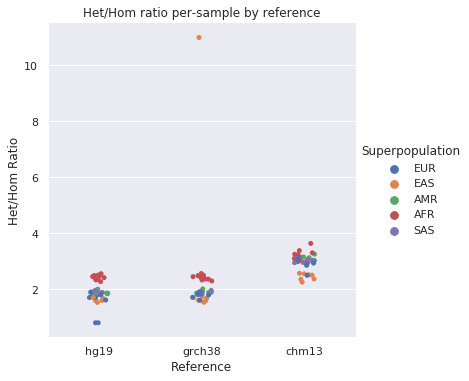

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     36.00  2.77 0.28 2.11 2.73 2.83 2.94  3.33
          INS     36.00  3.16 0.35 2.43 3.07 3.25 3.30  3.99
          TOT     36.00  2.96 0.31 2.26 2.92 3.03 3.13  3.64
grch38    DEL     36.00  2.54 1.65 1.68 2.10 2.18 2.64 11.97
          INS     36.00  2.10 1.46 1.46 1.66 1.75 2.19 10.45
          TOT     36.00  2.26 1.53 1.54 1.82 1.90 2.37 10.99
hg19      DEL     39.00  2.19 0.45 0.94 1.96 2.18 2.57  2.87
          INS     39.00  1.78 0.38 0.74 1.59 1.70 2.15  2.40
          TOT     39.00  1.93 0.41 0.81 1.71 1.88 2.31  2.56

In [28]:
loose_data = data[(data["merge"] == "loose")]

display(Markdown("# Loose Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
plot_sv_counts(loose_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
plot_svsize_counts(loose_data)
display(Markdown("## SV HET/HOM Ratios"))
hide = plot_hethom_stats(loose_data)